 # Decion based models. From decision Tree to Random Forest

### Load the California housing Dataset and Prepare the Data
- Load the California housing dataset from sklearn (`sklearn.datasets.fetch_california_housing()`).
- Separate the features and the target variable, which is 'medv' in this case.
- Analyse the dataset and process different necessary transformations of the data.
- Split the dataset

In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

In [4]:
import pandas as pd
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="MedHouseVal")

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42     
)

###  Fit the Regression Tree
- Fit a decision tree to the training data.
- Try to vizualize the behavior of the DT while changing parameters

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print("RMSE for train:",rmse_train)
print("RMSE for test:",rmse_test)

RMSE for train: 3.0302402915898627e-16
RMSE for test: 0.7068996727915191


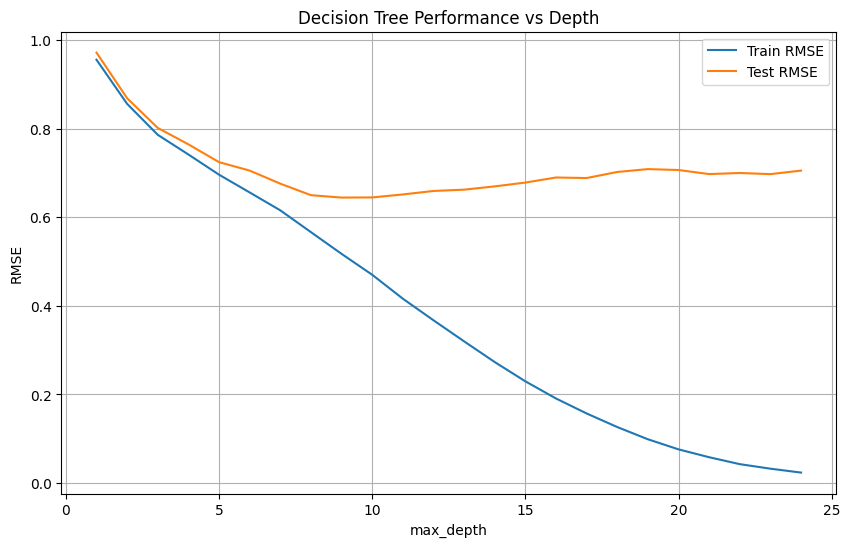

In [7]:
import matplotlib.pyplot as plt

depths = range(1, 25)
train_errors = []
test_errors = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_errors.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_errors.append(np.sqrt(mean_squared_error(y_test, test_pred)))

plt.figure(figsize=(10,6))
plt.plot(depths, train_errors, label="Train RMSE")
plt.plot(depths, test_errors, label="Test RMSE")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("Decision Tree Performance vs Depth")
plt.legend()
plt.grid(True)
plt.show()


### Perform Cost Complexity Pruning
- Apply cost complexity pruning to the regression tree using the appropriate library function : `cost_complexity_pruning_path()`
- Determine the optimal pruning parameter `ccp_alpha` through cross-validation

In [8]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np


tree = DecisionTreeRegressor(random_state=42)
path = tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas      
impurities = path.impurities      

unique_alphas = np.unique(ccp_alphas)

ccp_alphas_small = unique_alphas[::max(1, len(unique_alphas)//30)]

len(ccp_alphas_small)



31

In [9]:
trees = []
for alpha in ccp_alphas_small:
    t = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    t.fit(X_train, y_train)
    trees.append(t)


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_rmse = []
test_rmse = []

for t in trees:
    y_train_pred = t.predict(X_train)
    y_test_pred = t.predict(X_test)
    
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))


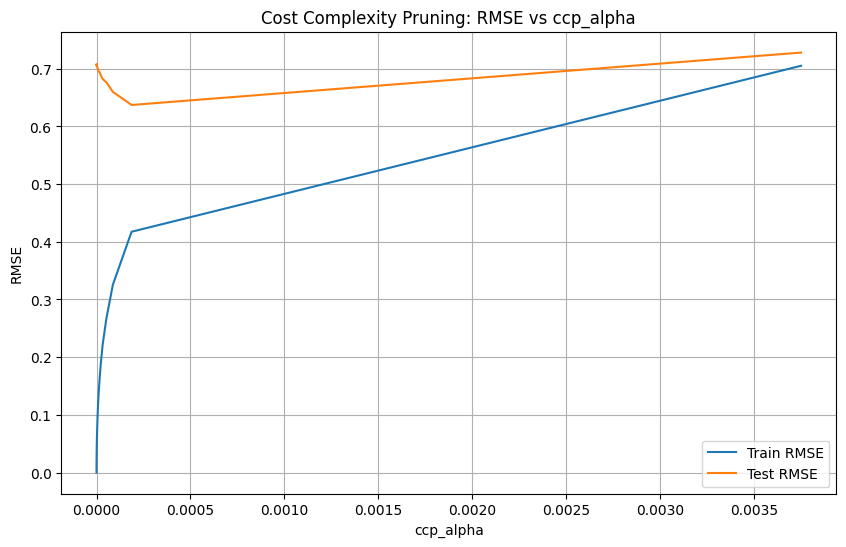

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(ccp_alphas_small, train_rmse, label="Train RMSE")
plt.plot(ccp_alphas_small, test_rmse, label="Test RMSE")
plt.xlabel("ccp_alpha")
plt.ylabel("RMSE")
plt.title("Cost Complexity Pruning: RMSE vs ccp_alpha")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
best_alpha = ccp_alphas_small[np.argmin(test_rmse)]
best_alpha

np.float64(0.00018678208489064207)

In [13]:
best_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
best_tree.fit(X_train, y_train)

y_pred = best_tree.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
best_rmse

np.float64(0.6370658585178538)

### Analyze the results
- Use the best estimator obtained from cross-validation to make predictions on the test set
- Utilize the `predict()` method of the best estimator to generate predictions for the test data
- Evaluate the Performance of the Model on the Test Set
- Plot the tree to see if its interpretable

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
y_pred = best_tree.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 0.6370658585178538
R²: 0.6902853118162322


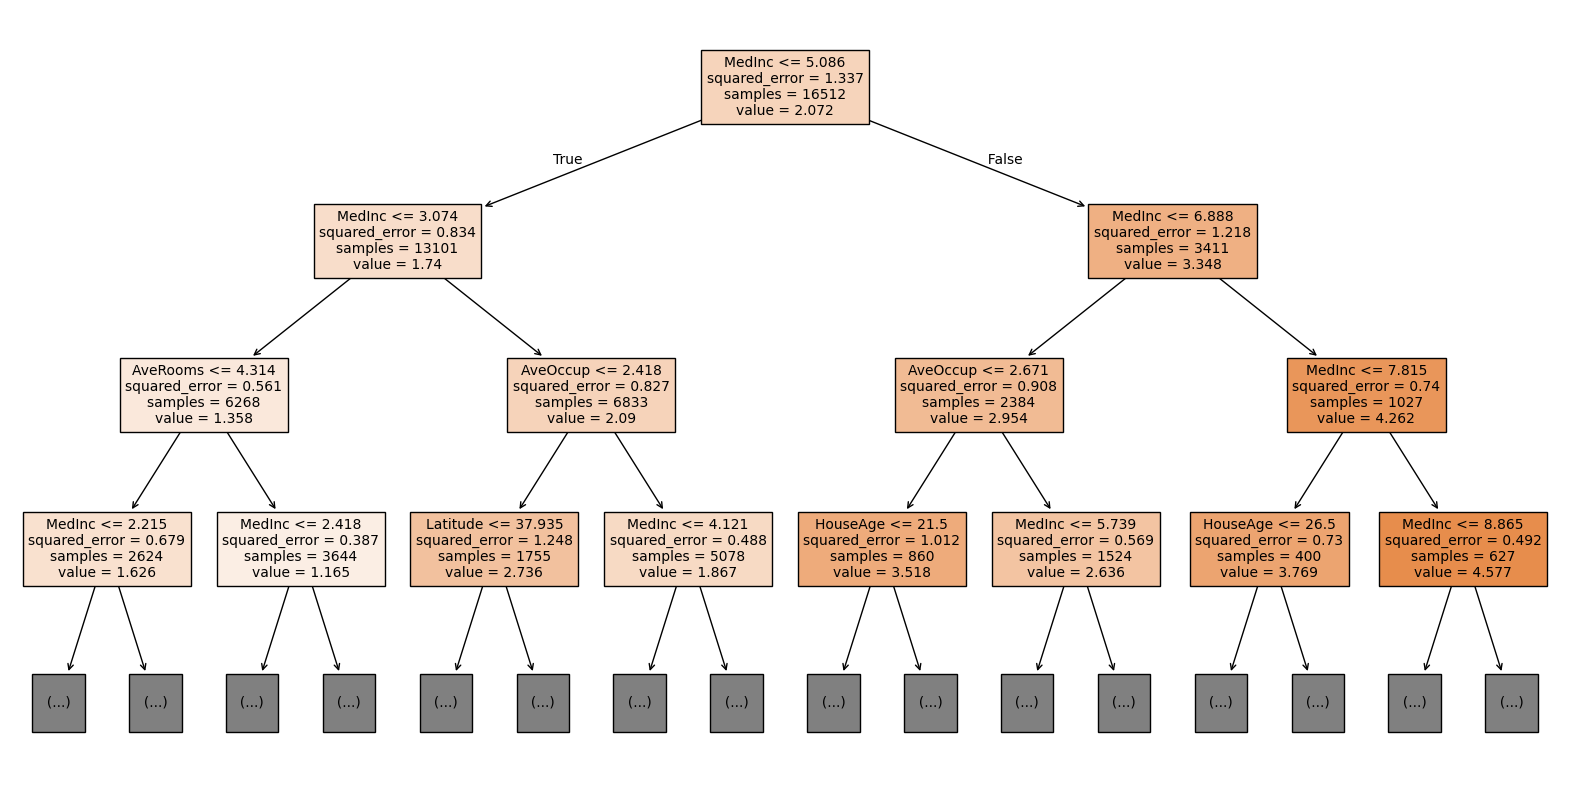

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.show()


### Some questions

- When learning the tree, we chose a feature to test at each step by maximizing the expected information gain. Does this approach allow us to generate the optimal decision
tree ? Why or why not ? Hint : When playing chess, do you consider only the immediate improvement of your position when deciding on your next move ?

- Why might a Decision Tree work well on a small dataset but perform poorly on a larger one ?

- How does the depth of the tree impact its performance in terms of overfitting and underfitting ?

- How are categorical features handled during splitting ?
 
- In your opinion, why is feature scaling not required when training a Decision Tree ?

- When splitting a node, what happens if all observations have the same target value ?

- What Decision Trees are often described as "white-box models". What does this mean, and why is it beneficial in certain applications ?

- If your dataset is imbalanced, how might this affect the splits chosen by the Decision Tree ? What adjustments could you make to address this ?

### Some answers
- No, maximizing information gain at each step does not guarantee the optimal decision tree.It only considers the next move, not the entire sequence of moves.When playing chess, choosing a move only because it gives the best immediate positional improvement usually leads to losing the game,because(A locally good move may ruin long-term strategy,the best overall result requires planning multiple steps ahead).Overall,best immediate split does not guarantee the best overall tree.
- If tree is too short we see underfitting, and vise-versa if it is too deep,we see overfitting.
- By encoding them before manipulations through OHE or ordinal encoding.
- Feature scaling is not required for Decision Trees, because trees split the data based on threshold comparisons, not distance calculations.The model only checks whether a feature value is greater or less than a threshold, the absolute scale does not matter.
- Node becomes a leaf,we don't split it further.
- Decision Trees are white-box models because every step of their prediction is visible and understandable to humans, making them ideal for applications that require transparency.
-An imbalanced dataset causes the decision tree to favor the majority class, leading to biased splits and poor minority-class performance.
We can address this by using class weights, resampling techniques, or adjusting tree parameters such as depth or pruning.

## Experiment Boostrapping

- Write a function that creates bootstrap samples by randomly sampling data points with replacement from the training set
- Train multiple Decision Tree models, each using a different bootstrap sample
- Generate predictions from each model for a fixed test set and store the results
- Compute the mean, standard deviation, and range of predictions for each test point across the models

In [16]:
import numpy as np

def bootstrap_sample(X, y):
    n = len(X)
    indices = np.random.randint(0, n, size=n)
    return X.iloc[indices], y.iloc[indices]


In [17]:
from sklearn.tree import DecisionTreeRegressor

n_models = 50
models = []

for i in range(n_models):
    X_bs, y_bs = bootstrap_sample(X_train, y_train)
    model = DecisionTreeRegressor(random_state=i)
    model.fit(X_bs, y_bs)
    models.append(model)

In [18]:
predictions = []

for model in models:
    preds = model.predict(X_test)
    predictions.append(preds)

predictions = np.array(predictions)  

In [19]:
mean_preds = predictions.mean(axis=0)
std_preds  = predictions.std(axis=0)
min_preds  = predictions.min(axis=0)
max_preds  = predictions.max(axis=0)
range_preds = max_preds - min_preds

- Create some vizualisation to compare the mean predictions with the true values
- Show the distribution of predictions for a few selected test points

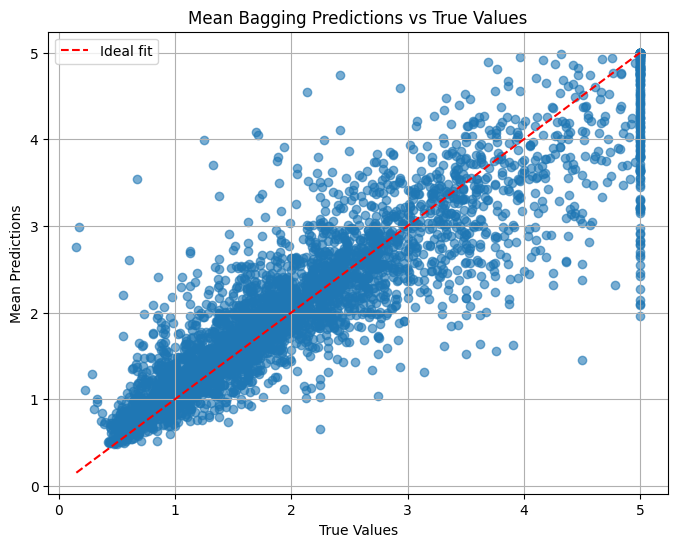

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, mean_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label="Ideal fit")

plt.xlabel("True Values")
plt.ylabel("Mean Predictions")
plt.title("Mean Bagging Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.show()


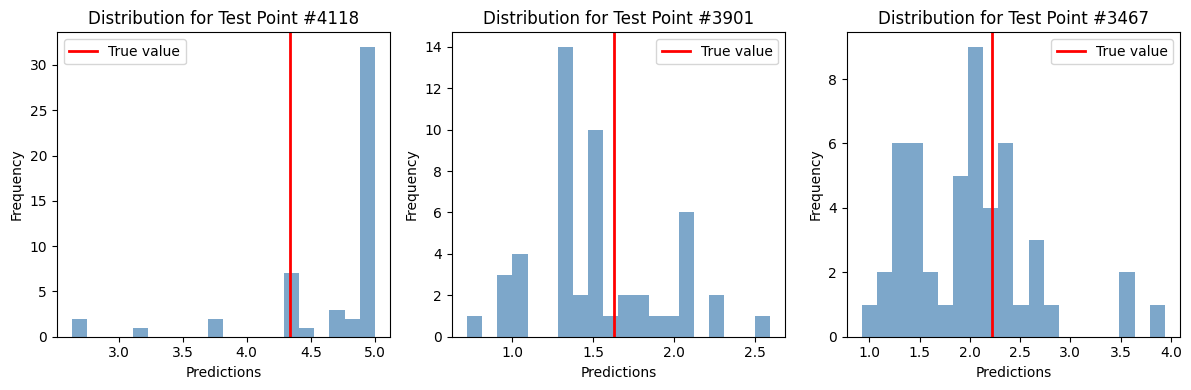

In [21]:
import numpy as np

selected = np.random.choice(len(X_test), size=3, replace=False)

plt.figure(figsize=(12, 4))

for i, idx in enumerate(selected):
    plt.subplot(1, 3, i+1)
    plt.hist(predictions[:, idx], bins=20, alpha=0.7, color='steelblue')
    plt.axvline(y_test.iloc[idx], color='red', linewidth=2, label="True value")
    plt.title(f"Distribution for Test Point #{idx}")
    plt.xlabel("Predictions")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

- How does the variance of predictions change across test samples ?
- Why do some test points exhibit higher variance ?
- How does this relate to the overfitting tendency of Decision Trees ?
- How might combining predictions help to reduce variance ?

### Answers
- Variance depends on how stable the decision tree’s splits are around that test point.
- Uncertain regions lead to higher prediction variance.
- High variance is a classic symptom of overfitting.
- Averaging many unstable models produces a low-variance ensemble.

- Try using a different weak learners with the same setup and compare their prediction variance
- Increase or decrease the number of bootstrap samples. How does this affect the results ?

In [22]:
import numpy as np

def bagging_predictions(model_class, X_train, y_train, X_test, n_models=50, **model_params):
    preds = []
    
    for i in range(n_models):
        idx = np.random.randint(0, len(X_train), len(X_train))
        X_bs = X_train.iloc[idx]
        y_bs = y_train.iloc[idx]
        
        
        model = model_class(**model_params)
        model.fit(X_bs, y_bs)
        
    
        preds.append(model.predict(X_test))
    
    return np.array(preds)     

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
#high variance
preds_tree = bagging_predictions(
    DecisionTreeRegressor,
    X_train, y_train, X_test,
    n_models=50,
    random_state=0
)
#low variance
preds_lin = bagging_predictions(
    LinearRegression,
    X_train, y_train, X_test,
    n_models=50
)

preds_knn = bagging_predictions(
    KNeighborsRegressor,
    X_train, y_train, X_test,
    n_models=50,
    n_neighbors=5
)

var_tree = preds_tree.var(axis=0)
var_lin  = preds_lin.var(axis=0)
var_knn  = preds_knn.var(axis=0)

/var/folders/l0/pbbr_nyj1y306_f2ys_mpgsh0000gn/T/ipykernel_6589/1891226873.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([var_tree, var_lin, var_knn],


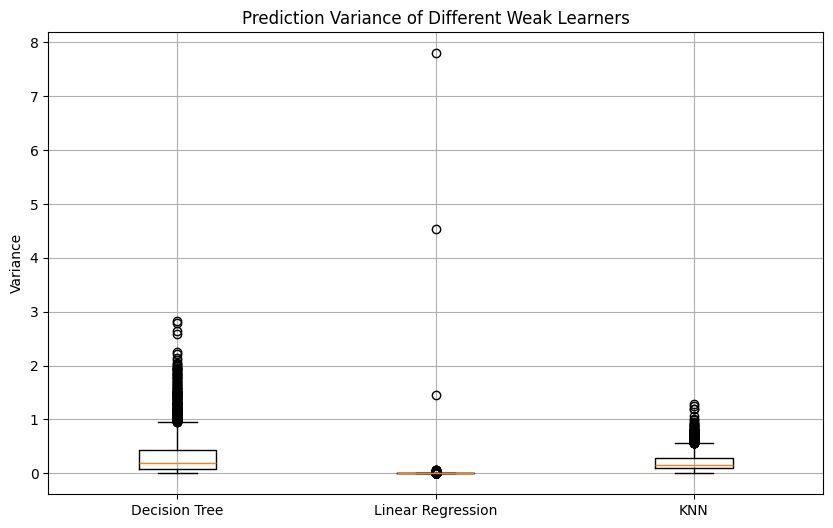

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.boxplot([var_tree, var_lin, var_knn],
            labels=['Decision Tree', 'Linear Regression', 'KNN'])
plt.title("Prediction Variance of Different Weak Learners")
plt.ylabel("Variance")
plt.grid(True)
plt.show()


In [25]:
model_sizes = [5, 20, 50, 200]
variances = []

for M in model_sizes:
    preds = bagging_predictions(
        DecisionTreeRegressor,
        X_train, y_train, X_test,
        n_models=M,
        random_state=0
    )
    variances.append(preds.var(axis=0).mean())


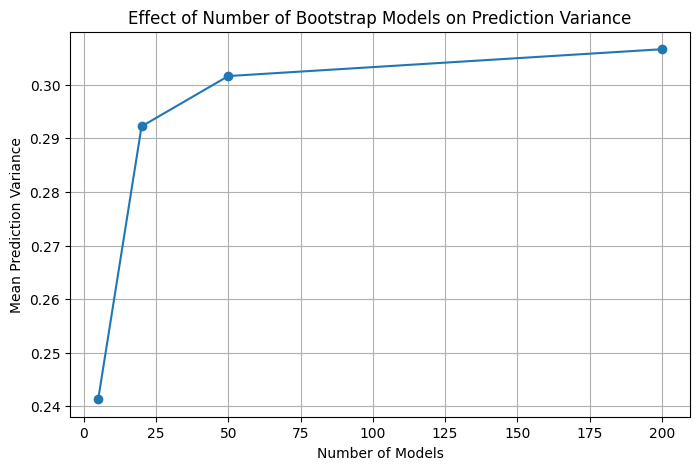

In [26]:
plt.figure(figsize=(8,5))
plt.plot(model_sizes, variances, marker="o")
plt.title("Effect of Number of Bootstrap Models on Prediction Variance")
plt.xlabel("Number of Models")
plt.ylabel("Mean Prediction Variance")
plt.grid(True)
plt.show()


### Bagging Implementation

- In order to improve the MSE and reduce the variance of the results implement your own Bagging class.

- Recall that Bagging is performed when all predictors (i.e. covariates - features) are used.

In [27]:
import numpy as np

class MyBaggingRegressor:
    def __init__(self, base_model, n_estimators=50):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def _bootstrap_sample(self, X, y):
        n = len(X)
        idx = np.random.randint(0, n, size=n)
        return X.iloc[idx], y.iloc[idx]

    def fit(self, X, y):
        self.models = []
        
        for i in range(self.n_estimators):
            X_bs, y_bs = self._bootstrap_sample(X, y)

            model = self.base_model()
            model.fit(X_bs, y_bs)
            self.models.append(model)

        return self

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return predictions.mean(axis=0)    


In [28]:
from sklearn.tree import DecisionTreeRegressor

bagger = MyBaggingRegressor(base_model=DecisionTreeRegressor, n_estimators=50)
bagger.fit(X_train, y_train)

y_pred_bag = bagger.predict(X_test)


In [29]:
from sklearn.metrics import mean_squared_error


tree = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Single Tree MSE:", mean_squared_error(y_test, y_pred_tree))
print("Bagging MSE:", mean_squared_error(y_test, y_pred_bag))

Single Tree MSE: 0.4991354665834061
Bagging MSE: 0.25830057175691545


In [30]:
all_preds = np.array([m.predict(X_test) for m in bagger.models])
variance = all_preds.var(axis=0).mean()

print("Average prediction variance across test samples:", variance)

Average prediction variance across test samples: 0.30473386125442514


- Fit your Bagging regressor to the training data. Compare it to `DecisionTree` Sklearn built-in class.

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

bagger = MyBaggingRegressor(base_model=DecisionTreeRegressor, n_estimators=50)
bagger.fit(X_train, y_train)

y_pred_bag = bagger.predict(X_test)

mse_bag = mean_squared_error(y_test, y_pred_bag)
print("Bagging Regressor MSE:", mse_bag)

Bagging Regressor MSE: 0.2569472644352744


In [32]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
print("Single Decision Tree MSE:", mse_tree)

Single Decision Tree MSE: 0.4987413784391715


In [33]:
print("----- Model Comparison -----")
print(f"Single Decision Tree MSE : {mse_tree:.4f}")
print(f"My Bagging Regressor MSE : {mse_bag:.4f}")
print("----------------------------")
print("Bagging improves the error by reducing variance.")

----- Model Comparison -----
Single Decision Tree MSE : 0.4987
My Bagging Regressor MSE : 0.2569
----------------------------
Bagging improves the error by reducing variance.


- Effect of Increasing Trees in Bagging : 
    - Vizualize the effect of increasing the number of weak learners. 
    - Does increasing the number of trees always help ?

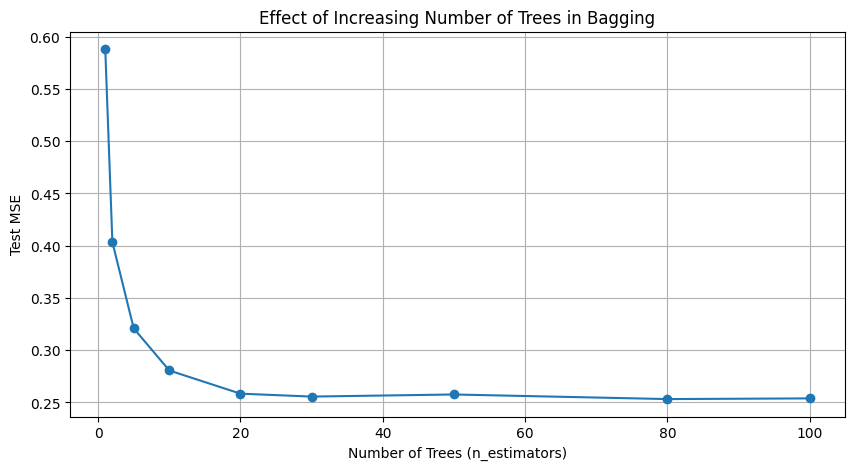

In [ ]:
#it helps only until some certain level
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_counts = [1, 2, 5, 10, 20, 30, 50, 80, 100]
mse_values = []

for n in tree_counts:
    bagger = MyBaggingRegressor(base_model=DecisionTreeRegressor, n_estimators=n)
    bagger.fit(X_train, y_train)
    y_pred = bagger.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

plt.figure(figsize=(10, 5))
plt.plot(tree_counts, mse_values, marker='o')
plt.title("Effect of Increasing Number of Trees in Bagging")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Test MSE")
plt.grid(True)
plt.show()


### Random Forest
Random Forest introduces additional randomness by restricting the number of features that each tree can consider when splitting a node.

Usually, $\sqrt{p}$ features for classification and $p/3$ for regression, where $p$ is the total number of features.

This restriction decorrelates the trees, reducing the chance of overfitting even further.

- Modify your class to chose the maximum number of features to consider when searching for the best split. 

In [38]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class MyRandomForestRegressor:
    def __init__(self, base_model=DecisionTreeRegressor, 
                 n_estimators=50, 
                 max_features=None):
        
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.max_features = max_features  # NEW
        self.models = []

    def bootstrap_sample(self, X, y):
        n = len(X)
        indices = np.random.randint(0, n, size=n)
        return X.iloc[indices], y.iloc[indices]


    def fit(self, X, y):
        self.models = []
        p = X.shape[1]

        
        if self.max_features is None:
            self.max_features = max(1, p // 3)

        for i in range(self.n_estimators):
            X_bs, y_bs = self.bootstrap_sample(X, y)

            model = self.base_model(
                max_features=self.max_features,
                random_state=i
            )

            model.fit(X_bs, y_bs)
            self.models.append(model)

    def predict(self, X):
        preds = np.array([model.predict(X) for model in self.models])
        return preds.mean(axis=0)


In [39]:
rf = MyRandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


- Create a plot displaying the test, train and OOB error resulting from random forests for a more comprehensive range of values for max_features and n_estimators
- Describe the results obtained

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimat

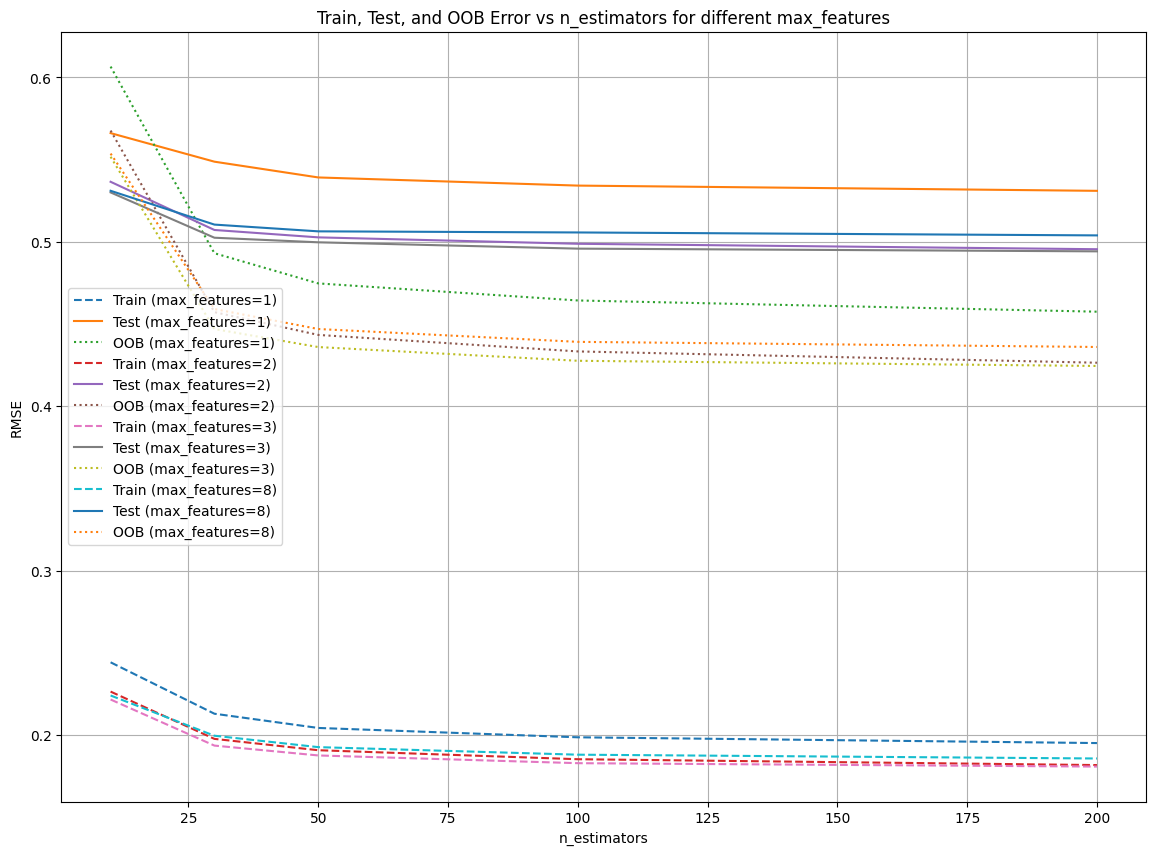

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

max_features_list = [1, 2, 3, X_train.shape[1]]  
n_estimators_list = [10, 30, 50, 100, 200]

results = {}

for mf in max_features_list:
    train_errors = []
    test_errors = []
    oob_errors = []

    for n in n_estimators_list:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_features=mf,
            oob_score=True,
            bootstrap=True,
            random_state=42
        )

        rf.fit(X_train, y_train)

        y_train_pred = rf.predict(X_train)
        y_test_pred = rf.predict(X_test)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        
        oob_rmse = np.sqrt(1 - rf.oob_score_)

        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
        oob_errors.append(oob_rmse)

    results[mf] = {
        "train": train_errors,
        "test": test_errors,
        "oob": oob_errors
    }

plt.figure(figsize=(14, 10))

for mf in max_features_list:
    plt.plot(n_estimators_list, results[mf]["train"], "--", label=f"Train (max_features={mf})")
    plt.plot(n_estimators_list, results[mf]["test"], "-", label=f"Test (max_features={mf})")
    plt.plot(n_estimators_list, results[mf]["oob"], ":", label=f"OOB (max_features={mf})")

plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("Train, Test, and OOB Error vs n_estimators for different max_features")
plt.legend()
plt.grid(True)
plt.show()


### Overall results
Increasing the number of trees always reduces variance, but only up to a point.
After approximately 100–200 trees, the model stabilizes and adding more trees does not significantly improve performance.

Smaller max_features values reduce correlation between trees, improving generalization and lowering both Test and OOB error.

OOB error closely tracks Test error, confirming its usefulness as an internal validation metric.

- Visualize the difference in variance between your Decision Tree and Random Forest (which you can replicate with different parameters).

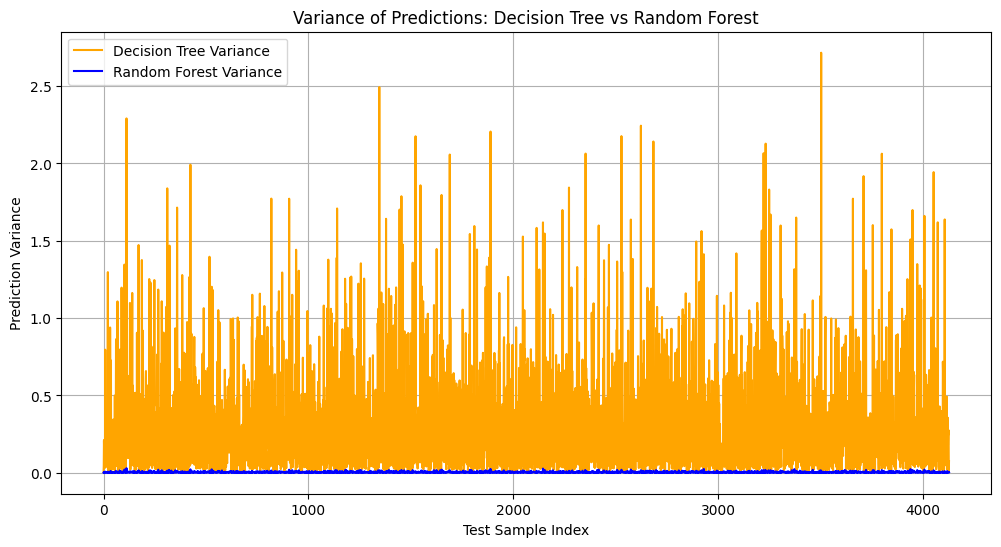

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

n_models = 50
tree_predictions = []

for i in range(n_models):
    idx = np.random.randint(0, len(X_train), len(X_train))
    X_bs, y_bs = X_train.iloc[idx], y_train.iloc[idx]

    tree = DecisionTreeRegressor(random_state=i)
    tree.fit(X_bs, y_bs)
    tree_predictions.append(tree.predict(X_test))

tree_predictions = np.array(tree_predictions)
tree_variance = tree_predictions.var(axis=0)

rf_predictions = []

for i in range(n_models):
    rf = RandomForestRegressor(
        n_estimators=100,
        max_features="sqrt",
        bootstrap=True,
        random_state=i
    )
    rf.fit(X_train, y_train)
    rf_predictions.append(rf.predict(X_test))

rf_predictions = np.array(rf_predictions)
rf_variance = rf_predictions.var(axis=0)


plt.figure(figsize=(12,6))
plt.plot(tree_variance, label="Decision Tree Variance", color="orange")
plt.plot(rf_variance, label="Random Forest Variance", color="blue")
plt.title("Variance of Predictions: Decision Tree vs Random Forest")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction Variance")
plt.legend()
plt.grid(True)
plt.show()


--- 